# Project 3:  Implement SLAM - "extra credit"

---

## Project Overview

This addition to the project implements a suggestion in the rubric, to only consider the most recent pose. My attempt will be assisted by the concepts Sebastian Thrun conveys in this youtube video about "Online SLAM", in which this precise topic is taken up: https://www.youtube.com/watch?v=jaeNlxhQL1I. Other changes:
1. MyOnlineSlam is now implemented as a class
1. The data loop happens outside of the class.
1. The x and y xi vectors are separated. Omega is the same for both.

I will also be attempting to make a short video of the movements of the robot. For plotting purposes I have to use a modified version of "make_data" because the robot's ground truth position was not being saved anywhere.

## Create the world

In my world, the number of landmarks increases to ten, the robot doesn't move as far in each step and can't sense as far; therefore the number of time steps increases in order to be able to cover most of the world space.


In [65]:
import numpy as np
from helpers import check_for_data

# your implementation of slam should work with the following inputs
# feel free to change these input values and see how it responds!

# world parameters
num_landmarks      = 10       # number of landmarks
N                  = 100      # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 30.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 10.0     # distance by which robot (intends to) move each iteratation 

In [66]:
from robot_class import robot
import random
from math import *

# --------
# this routine makes the robot data
# the data is a list of measurements and movements: [measurements, [dx, dy]]
# collected over a specified number of time steps, N
#
def my_make_data(N, num_landmarks, world_size, measurement_range, motion_noise, 
                 measurement_noise, distance):
    pass

    # check that data has been made
    try:
        check_for_data(num_landmarks, world_size, measurement_range, motion_noise, measurement_noise)
    except ValueError:
        print('Error: You must implement the sense function in robot_class.py.')
        return []
    
    complete = False
    
    r = robot(world_size, measurement_range, motion_noise, measurement_noise)
    r.make_landmarks(num_landmarks)

    while not complete:

        data = []

        seen = [False for row in range(num_landmarks)]
    
        # guess an initial motion
        orientation = random.random() * 2.0 * pi
        dx = cos(orientation) * distance
        dy = sin(orientation) * distance
            
        for k in range(N-1):
    
            # collect sensor measurements in a list, Z
            Z = r.sense()

            # check off all landmarks that were observed 
            for i in range(len(Z)):
                seen[Z[i][0]] = True
    
            # move
            while not r.move(dx, dy):
                # if we'd be leaving the robot world, pick instead a new direction
                orientation = random.random() * 2.0 * pi
                dx = cos(orientation) * distance
                dy = sin(orientation) * distance

            # collect/memorize all sensor and motion data
            # UPDATE: ADD GROUND TRUTH POSITION FOR PLOTTING PURPOSES
            #
            data.append([Z, [dx, dy], [r.x, r.y]])

        # we are done when all landmarks were observed; otherwise re-run
        complete = (sum(seen) == num_landmarks)

    print(' ')
    print('Landmarks: ', r.landmarks)
    print(r)


    return data, r.landmarks

# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data, gt_landmarks = my_make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[88, 13], [67, 23], [43, 67], [21, 13], [70, 39], [91, 56], [96, 95], [10, 84], [99, 86], [32, 2]]
Robot: [x=67.64845 y=14.58713]


In [15]:
# print out some stats about the data
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[6, -23.430945649015158, -17.776464278716304], [8, -24.12364917479613, 3.1955335627616783]]


Example motion: 
 [-7.437925720922407, -6.6841050986681]


## Class MyOnlineSLAM

In [16]:
class MyOnlineSLAM(object):
    def __init__(self,num_landmarks, world_size, motion_noise, measurement_noise):
        self.size = 1+num_landmarks
        
        self.omega = np.zeros((self.size,self.size)) # same for x and y
        self.omega[0,0] = 1  # initial location constraint

        self.xi_x = np.zeros((self.size))
        self.xi_y = np.zeros((self.size))
        self.xi_x[0] = self.xi_y[0] = world_size/2 # init location constraint
        
        # weights for omega/xi
        self.Wms = 1.0/measurement_noise
        self.Wmo = 1.0/motion_noise
        
        self.verbose = False
        
        np.set_printoptions(precision=2, suppress=True, linewidth=128)

    def update_ms(self, measurements):
        for m in measurements:
            lm_j, lm_dx, lm_dy = m[0], m[1], m[2]
            lm_j = 1 + lm_j
            
            self.omega[0,0]       += self.Wms   # 0.x <-> 0.x
            self.omega[0,lm_j]    -= self.Wms   # 0.x <-> lm_j.x
            self.omega[lm_j,0]    -= self.Wms   # lm_j.x <-> 0.x
            self.omega[lm_j,lm_j] += self.Wms   # lm_j.x <-> lm_j.x
            
            self.xi_x[0]          -= lm_dx*self.Wms
            self.xi_y[0]          -= lm_dy*self.Wms
            self.xi_x[lm_j]       += lm_dx*self.Wms
            self.xi_y[lm_j]       += lm_dy*self.Wms

    def update_mo(self, motion):
        ## This suddenly got complicated. 
        ##    -- see https://www.youtube.com/watch?v=jaeNlxhQL1I
        ## 1. "Expand" omega and xi's by 1 in rows and cols representing new pose
        ## 2. Perform motion update
        ## 3. Fold old pose information into the new omega and xi's
        ## 4. Shrink omega and xi's back to their original sizes by eliminating old pose.
        ##
        if self.verbose:
            print ("----------------- MOTION UPDATE: ")
            print ("({0:.3f},{1:.3f})".format(motion[0],motion[1]))
        
        last = self.size
        new_omega                    = np.zeros((last+1,last+1))
        new_omega[2:last+1,2:last+1] = self.omega[1:last,1:last].copy()
        new_omega[0,2:last+1]        = self.omega[0,1:last].copy()   # first row moves up
        new_omega[2:last+1,0]        = self.omega[1:last,0].copy()   # first col moves left
        new_omega[0,0]               = self.omega[0,0]               # upper left corner
        
        if self.verbose:
            print ("----------------- Copied self to new")
            print ("self.omega: ")
            print (self.omega)
            print ("new_omega: ")
            print (new_omega)
        
        # zeroed row and col 1 now ready for new pose, perform update
        new_omega[0,0] += self.Wmo   # t.x
        new_omega[1,1] += self.Wmo   # t+1.x
        new_omega[0,1] -= self.Wmo   # t.x <-> t+1.x
        new_omega[1,0] -= self.Wmo   # t+1.x <-> t.x
        
        # same for xi:
        new_xi_x           = np.zeros((last+1))
        new_xi_y           = np.zeros((last+1))
        new_xi_x[2:last+1] = self.xi_x[1:last].copy()
        new_xi_y[2:last+1] = self.xi_y[1:last].copy()
        new_xi_x[0]        = self.xi_x[0]
        new_xi_y[0]        = self.xi_y[0]
        
        if self.verbose:
            print ("----------------- created new xi's")
            print ("self.xi_x: ", self.xi_x)
            print ("new_xi_x : ", new_xi_x)
            print ("self.xi_y: ", self.xi_y)
            print ("new_xi_y : ", new_xi_y)
        
        new_xi_x[0] -= self.Wmo * motion[0]
        new_xi_x[1] += self.Wmo * motion[0]

        new_xi_y[0] -= self.Wmo * motion[1]
        new_xi_y[1] += self.Wmo * motion[1]
        
        if self.verbose:
            print ("----------------- After motion update")
            print ("new_omega:")
            print (new_omega)
            print ("new_xi_x: ", new_xi_x)
            print ("new_xi_y: ", new_xi_y)

        # Shrinking omega and xi's back
        self.omega = new_omega[1:last+1,1:last+1].copy()
        self.xi_x  = new_xi_x[1:last+1].copy()
        self.xi_y  = new_xi_y[1:last+1].copy()
        
        # Now form A, B, and C from old pose info
        A   = new_omega[0,1:last+1].copy().reshape(1,-1) # row vector
        B   = new_omega[0,0]
        C_x = new_xi_x[0]
        C_y = new_xi_y[0]

        if self.verbose:
            print ("----------------- New back to self, A, B, C's")
            print ("from new:")
            print (new_omega)
            print ("to self:")
            print (self.omega)
            print ("A: ")
            print (A)
            print ("B: ", B)
            print ("new_xi_x : ", new_xi_x)
            print ("self.xi_x: ", self.xi_x)
            print ("C_x : ", C_x)
            print ("new_xi_y : ", new_xi_y)
            print ("self.xi_y: ", self.xi_y)
            print ("C_y : ", C_y)
        
        AtBinv    = A.T/B
        AtBinvA   = np.dot(AtBinv,A)
        AtBinvC_x = C_x*AtBinv
        AtBinvC_y = C_y*AtBinv

        if self.verbose:
            print ("-----------------")
            print ("AtBinv:")
            print (AtBinv)
            print ("AtBinvA: ")
            print (AtBinvA)
            print ("AtBinvC_x: ")
            print (AtBinvC_x)
            print ("AtBinvC_y: ")
            print (AtBinvC_y)
        
        # Folding old pose info back into omega/xi
        self.omega  -= AtBinvA
        self.xi_x   -= np.squeeze(AtBinvC_x)
        self.xi_y   -= np.squeeze(AtBinvC_y)

        if self.verbose:
            print ("----------------- After folding")
            print ("omega:")
            print (self.omega)
            print ("xi_x: ", self.xi_x)
            print ("xi_y: ", self.xi_y)
        
    def __call__(self,measurements, motion):
        
        self.update_ms(measurements)
        self.update_mo(motion)
        
    def get_mu(self):
        ## Compute the best estimate of current pose and landmarks at each time step
        ## using the formula, omega_inverse * Xi
        try:
            omega_inv = np.linalg.inv(self.omega)
        except np.linalg.LinAlgError as err:
            return None
        
        mu_x, mu_y = np.dot(omega_inv, self.xi_x), np.dot(omega_inv, self.xi_y)
        mu = np.concatenate((mu_x.reshape(-1,1),
                             mu_y.reshape(-1,1)), axis=1)
        
        if self.verbose:
            print ("----------------- Calc mu")
            print ("omega:")
            print (self.omega)
            print ("omega_inv:")
            print (omega_inv)
            print ("xi_x: ", self.xi_x)
            print ("xi_y: ", self.xi_y)
            print ("mu_x: ", mu_x)
            print ("mu_y: ", mu_y)

        return mu

    def get_omega_xi(self):
        xi = np.concatenate((self.xi_x.reshape(-1,1),
                             self.xi_y.reshape(-1,1)), axis=1)
        return self.omega, xi

myslam = MyOnlineSLAM(num_landmarks, world_size, motion_noise, measurement_noise)

## Helper functions

To check that your implementation of SLAM works for various inputs, we have provided two helper functions that will help display the estimated pose and landmark locations that your function has produced. First, given a result `mu` and number of time steps, `N`, we define a function that extracts the poses and landmarks locations and returns those as their own, separate lists. 

Then, we define a function that nicely print out these lists; both of these we will call, in the next step.


In [17]:
# a helper function that returns the last pose and a list of landmarks for ease of printing
def get_pose_landmarks(mu):
    pose = mu[0]
    landmarks = mu[1:]
    return pose, landmarks

In [18]:
def print_all(lastpose, landmarks):
    print('\n')
    print('Estimated Last Pose:')
    print(lastpose)
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print(landmarks[i])

In [58]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import seaborn as sns

# Have to modify display_world for this notebook
# from helpers import display_world

def my_display_world(world_size, 
                     gtpose, gtlms,            # ground truth positions
                     measpose=None, measlms=None,  # measured positions
                     measurements=None,
                     save_file=False):
    
    global plt
    global count
    
    # using seaborn, set background grid to gray
    sns.set_style("dark")

    # Plot grid of values
    world_grid = np.zeros((world_size+1, world_size+1))

    # Set minor axes in between the labels
    #import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = plt.gca()
    cols = world_size+1
    rows = world_size+1

    ax.set_xticks([x for x in range(1,cols)],minor=True )
    ax.set_yticks([y for y in range(1,rows)],minor=True)
    
    # Plot grid on minor axes in gray (width = 1)
    plt.grid(which='minor',ls='-',lw=1, color='white')
    
    # Plot grid on major axes in larger width
    plt.grid(which='major',ls='-',lw=2, color='white')

    # Create an 'o' character that represents the robot
    # ha = horizontal alignment, va = vertical
    ax.text(gtpose[0], gtpose[1], 'o', ha='center', va='center', color='purple', fontsize=30)

    if (measpose is not None):
        ax.text(measpose[0], measpose[1], 'o', ha='center', va='center', color='r', fontsize=30)

    circle = plt.Circle(gtpose, measurement_range, color='r', alpha=0.1)

    ax.add_artist(circle)

    # Draw ground truth landmarks if they exists
    if(gtlms is not None):
        for pos in gtlms:
            ax.text(pos[0], pos[1], 'x', ha='center', va='center', color='purple', fontsize=20)
    
    # Draw landmark estimates if they exists
    if(measlms is not None):
        for pos in measlms:
            ax.text(pos[0], pos[1], 'x', ha='center', va='center', color='red', fontsize=20)

    # Draw measurements as lines radiating from the ground truth position
    if(measurements is not None):
        for m in measurements:
            lm_j, lm_dx, lm_dy = m[0], m[1], m[2]
            if measlms is not None:
                pos = measlms[lm_j]
            else:
                pos = np.array(gtpose) + np.array([lm_dx, lm_dy])
            con = ConnectionPatch(gtpose, pos, "data",color="r")
            ax.add_artist(con)

    # Display final result
    if save_file:
        fig.savefig('image{0:02d}.png'.format(count), bbox_inches='tight')
        count = count + 1
        plt.close(fig)
    else:
        plt.show()

## Run SLAM

In [67]:
# define figure size
plt.rcParams["figure.figsize"] = (20,20)

count = 0

myslam = MyOnlineSLAM(num_landmarks, world_size, motion_noise, measurement_noise)

gtpose = [world_size/2, world_size/2]

# Save initial position
my_display_world(int(world_size), gtpose, gt_landmarks,save_file=True)

# call your implementation of slam, passing in the necessary parameters
for sample in data:
    measurements, motion, gtpose = sample
    myslam(measurements, motion)
    mu = myslam.get_mu()
    if(mu is not None):
        measpose, measlms = get_pose_landmarks(mu)
        my_display_world(int(world_size), gtpose, gt_landmarks, 
                         measpose, measlms, measurements, save_file=True)
    else:
        my_display_world(int(world_size), gtpose, gt_landmarks,
                         measurements=measurements, save_file=True)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    lastpose, landmarks = get_pose_landmarks(mu)
    print_all(lastpose, landmarks)



Estimated Last Pose:
[ 68.84  14.44]


Estimated Landmarks:
[ 88.68  13.31]
[ 67.05  23.53]
[ 43.88  68.06]
[ 21.14  14.55]
[ 70.32  39.91]
[ 90.67  57.  ]
[ 96.14  96.21]
[ 10.98  84.08]
[ 98.46  87.31]
[ 32.14   3.86]


In [68]:
!zip images.zip image*.png
!rm image*.png

  adding: image00.png (deflated 32%)
  adding: image01.png (deflated 19%)
  adding: image02.png (deflated 22%)
  adding: image03.png (deflated 25%)
  adding: image04.png (deflated 30%)
  adding: image05.png (deflated 32%)
  adding: image06.png (deflated 31%)
  adding: image07.png (deflated 28%)
  adding: image08.png (deflated 24%)
  adding: image09.png (deflated 23%)
  adding: image10.png (deflated 23%)
  adding: image11.png (deflated 24%)
  adding: image12.png (deflated 25%)
  adding: image13.png (deflated 27%)
  adding: image14.png (deflated 31%)
  adding: image15.png (deflated 37%)
  adding: image16.png (deflated 40%)
  adding: image17.png (deflated 39%)
  adding: image18.png (deflated 34%)
  adding: image19.png (deflated 31%)
  adding: image20.png (deflated 34%)
  adding: image21.png (deflated 35%)
  adding: image22.png (deflated 34%)
  adding: image23.png (deflated 35%)
  adding: image24.png (deflated 38%)
  adding: image25.png (deflated 35%)
  adding: image26.png (deflated 37%)
 

## Visualize the constructed world

Finally, using the `display_world` code from the `helpers.py` file (which was also used in the first notebook), we can actually visualize what you have coded with `slam`: the final position of the robot and the positon of landmarks, created from only motion and measurement data!

**Note that these should be very similar to the printed *true* landmark locations and final pose from our call to `make_data` early in this notebook.**

Last pose:  [ 68.84  14.44]


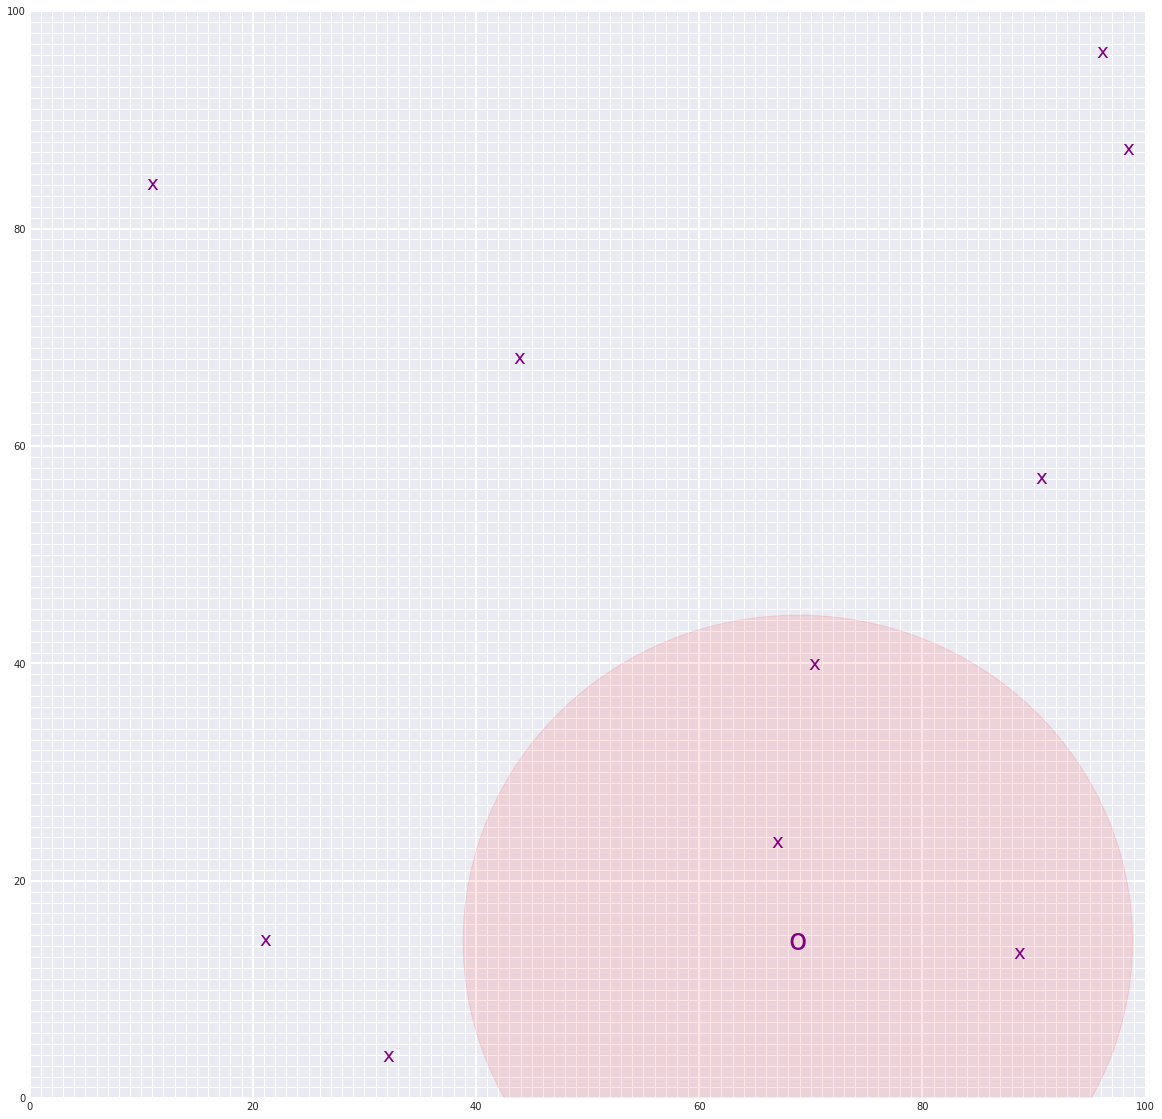

In [69]:
# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'lastpose' in locals():
    # print out the last pose
    print('Last pose: ', lastpose)
    # display the last position of the robot *and* the landmark positions
    my_display_world(int(world_size), lastpose, landmarks, save_file=False)

## Visualize Omega and Xi

In [70]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

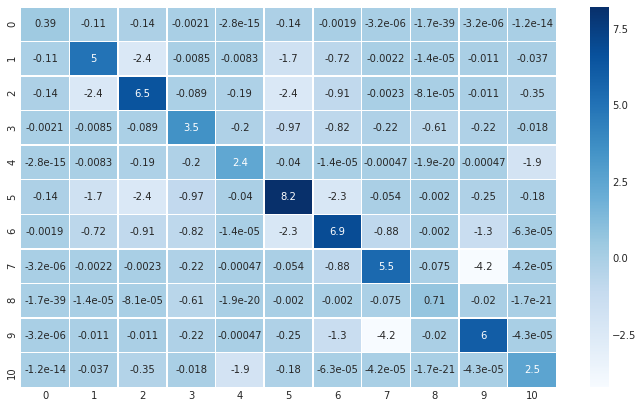

In [71]:
# define figure size
plt.rcParams["figure.figsize"] = (12,7)

omega, xi = myslam.get_omega_xi()

# display omega
sns.heatmap(DataFrame(omega), cmap='Blues', annot=True, linewidths=.5)

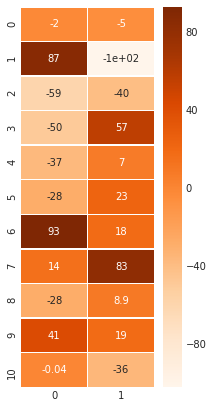

In [72]:
# define  figure size
plt.rcParams["figure.figsize"] = (3,7)

# display xi
sns.heatmap(DataFrame(xi), cmap='Oranges', annot=True, linewidths=.5)